In [89]:
print(1+2)

3


In [90]:
import qiskit
print(qiskit.__version__)

0.45.0


In [91]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)

0.10.0


In [92]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram



<br>

**Quantum Fourier Transform**

---

Circuit Diagram:


/Users/shyam/Documents/Quantum Projects/qiskit_nex/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


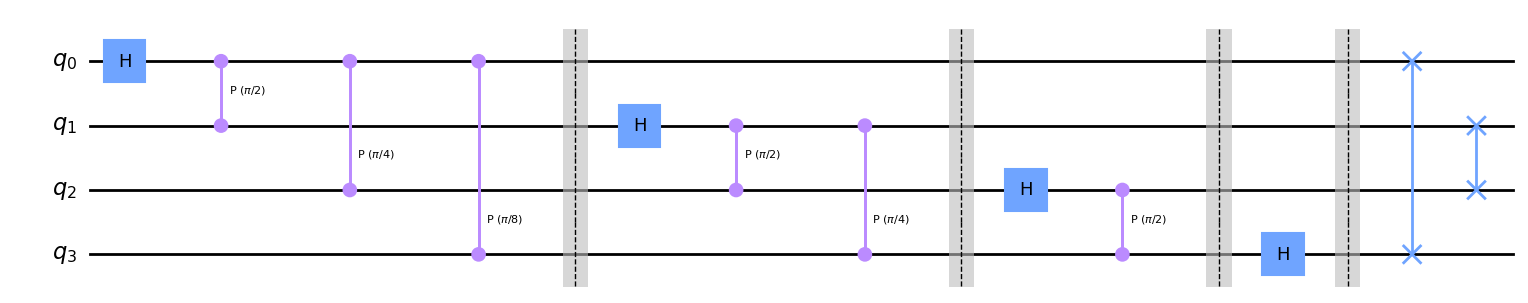

In [93]:

# 1. Define the QFT Function
def make_qft_circuit(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    # Add Rotations
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
        qc.barrier()
            
    # Add Swaps to reverse qubit order
    for i in range(n_qubits // 2):
        qc.swap(i, n_qubits - i - 1)
        
    return qc

n = 4
qft_circuit = make_qft_circuit(n)
print("Circuit Diagram:")
qft_circuit.draw("mpl")


<br>

**QFT gate**

---

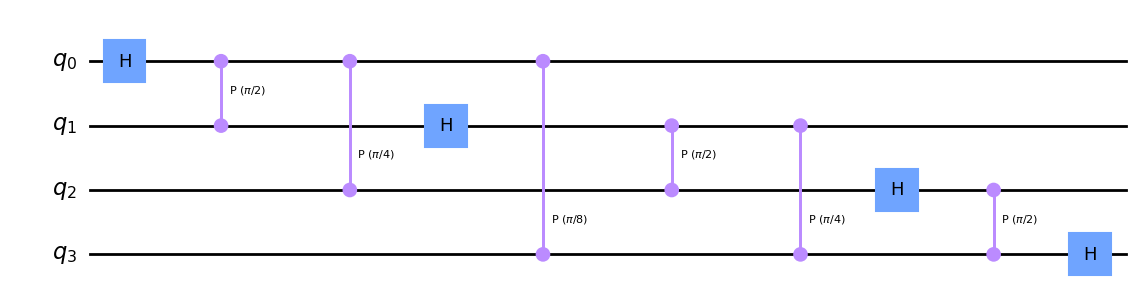

In [94]:

def make_QFT(n_qubits, do_swaps=True):
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
            
    if do_swaps:
        for i in range(n_qubits // 2):
            qc.swap(i, n_qubits - i - 1)
    
    qft_qc = qc.to_gate()
    qft_qc.name="QFT"
    return qft_qc

n = 4
qft_gate = make_QFT(n, do_swaps=False)
qft_gate.definition.draw("mpl")


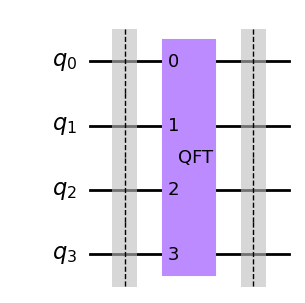

In [95]:

qc = QuantumCircuit(n)

qc.barrier()
qc.append(qft_gate, range(n))
qc.barrier()

qc.draw("mpl")
# qc.decompose().draw("mpl")


<br>

**IQFT gate**

---

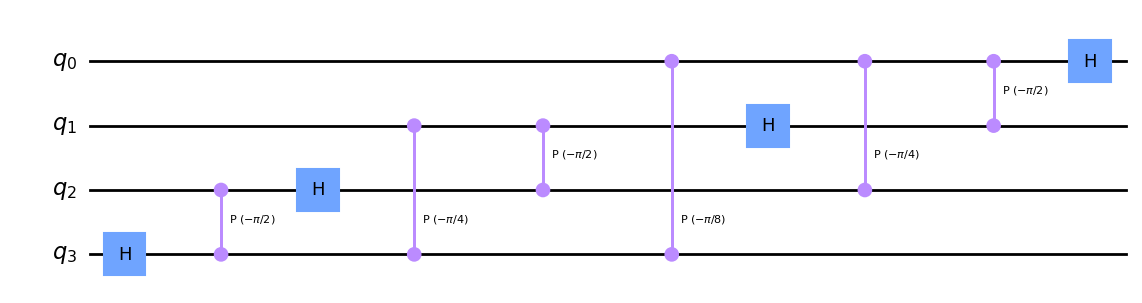

In [96]:
iqft_gate = qft_gate.inverse()
iqft_gate.name="IQFT"
iqft_gate.definition.draw("mpl")

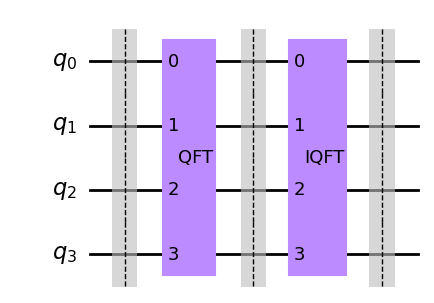

In [97]:
qc.append(iqft_gate, range(n))
qc.barrier()
qc.draw("mpl")


<br>

**visualizing a number on qft and applying IQFT to recover number**

---

In [98]:
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator


num = 30
print(f"binary of {num} = {bin(num)}")

n_qubits = num.bit_length()
print("qubits needed =", n_qubits)

bitstring = format(num, f"0{n_qubits}b")[::-1]
print(f"bit-string : {bitstring}")


binary of 30 = 0b11110
qubits needed = 5
bit-string : 01111


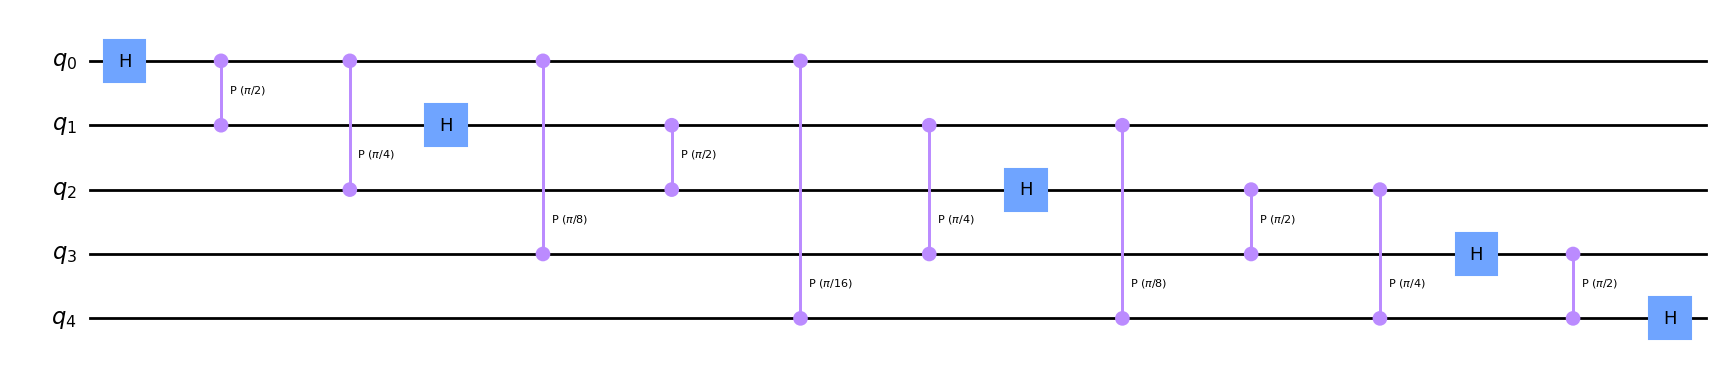

In [99]:

def make_QFT(n_qubits, do_swaps=True):
    qc = QuantumCircuit(n_qubits)
    
    for i in range(n_qubits):
        qc.h(i)
        for j in range(i+1, n_qubits):
            angle = np.pi / (2 ** (j - i))
            qc.cp(angle, j, i)
            
    if do_swaps:
        for i in range(n_qubits // 2):
            qc.swap(i, n_qubits - i - 1)
    
    qft_qc = qc.to_gate()
    qft_qc.name="QFT"
    return qft_qc

qft_gate = make_QFT(n_qubits, do_swaps=False)
qft_gate.definition.draw("mpl")


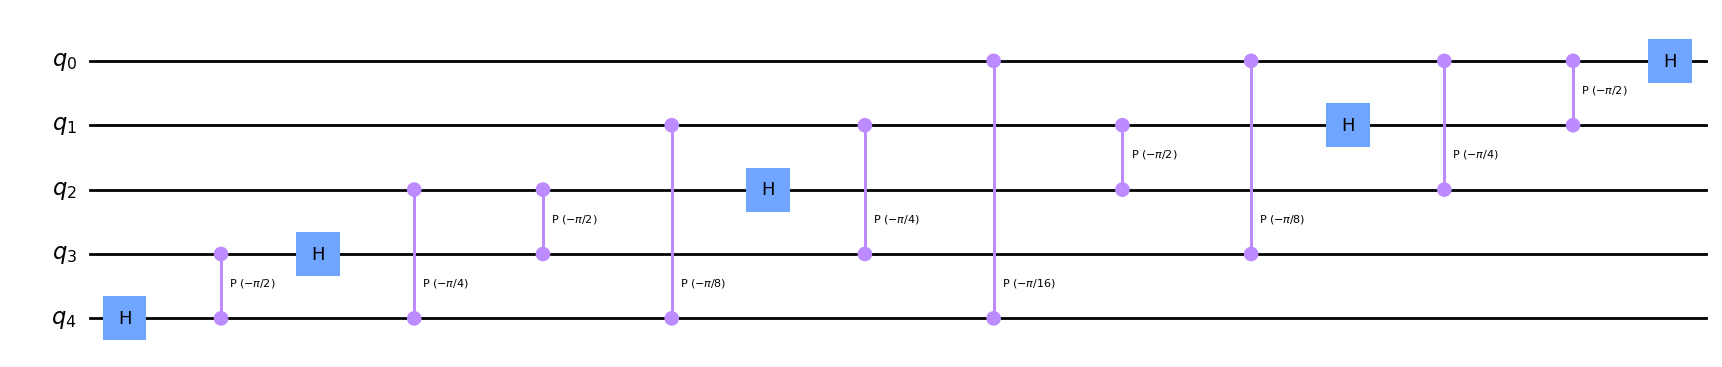

In [100]:

iqft_gate = qft_gate.inverse()
iqft_gate.name="IQFT"
iqft_gate.definition.draw("mpl")

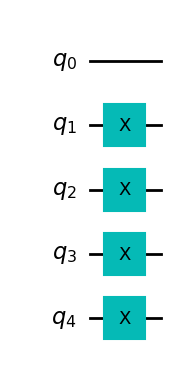

In [101]:
qc = QuantumCircuit(n_qubits)
for idx, bit in enumerate(bitstring):
    if bit == '1':
        qc.x(idx)
qc.draw("mpl")

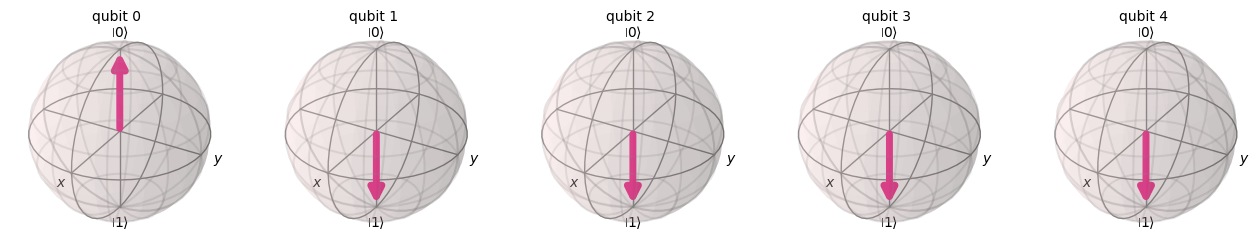

In [102]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

plot_bloch_multivector(qc)

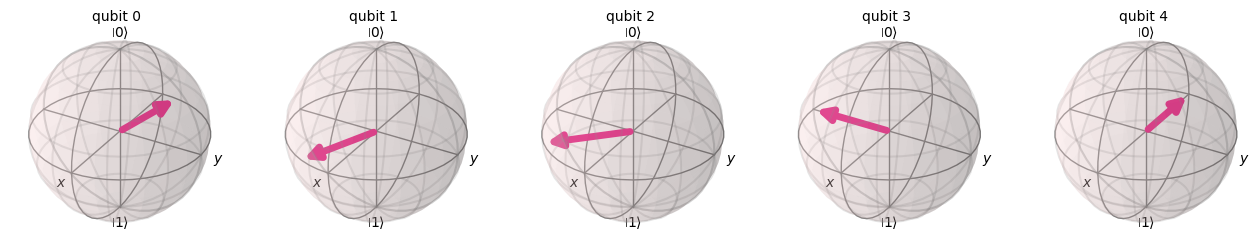

In [103]:
qc.barrier()
qc.append(qft_gate, range(n_qubits))

plot_bloch_multivector(qc)

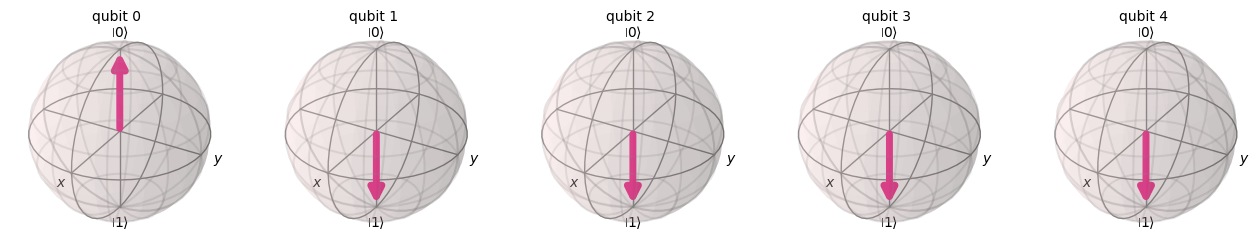

In [104]:
qc.barrier()
qc.append(iqft_gate, range(n_qubits))
plot_bloch_multivector(qc)

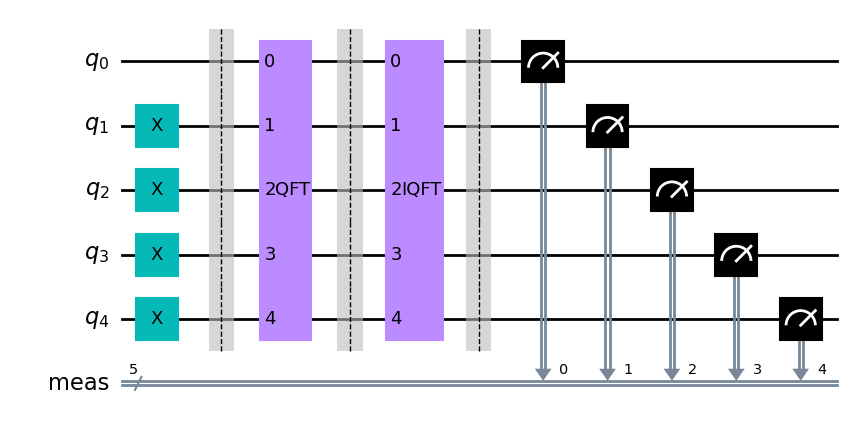

In [105]:
qc.measure_all()
qc.draw("mpl")

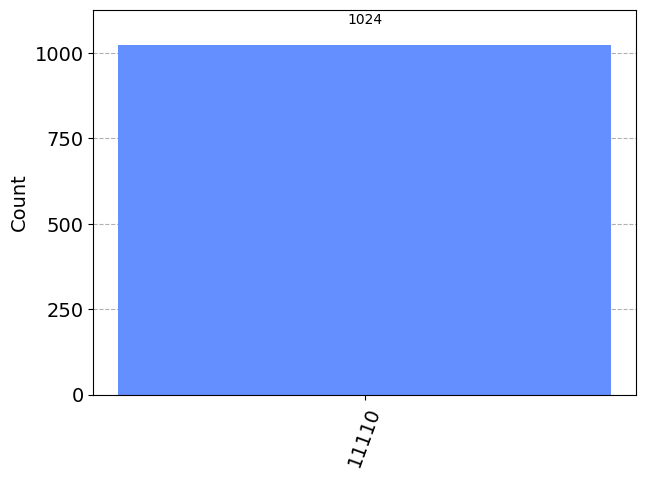

In [106]:
from qiskit.visualization import plot_histogram

simulator = AerSimulator()

compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)

result = job.result()
counts = result.get_counts()

plot_histogram(counts)

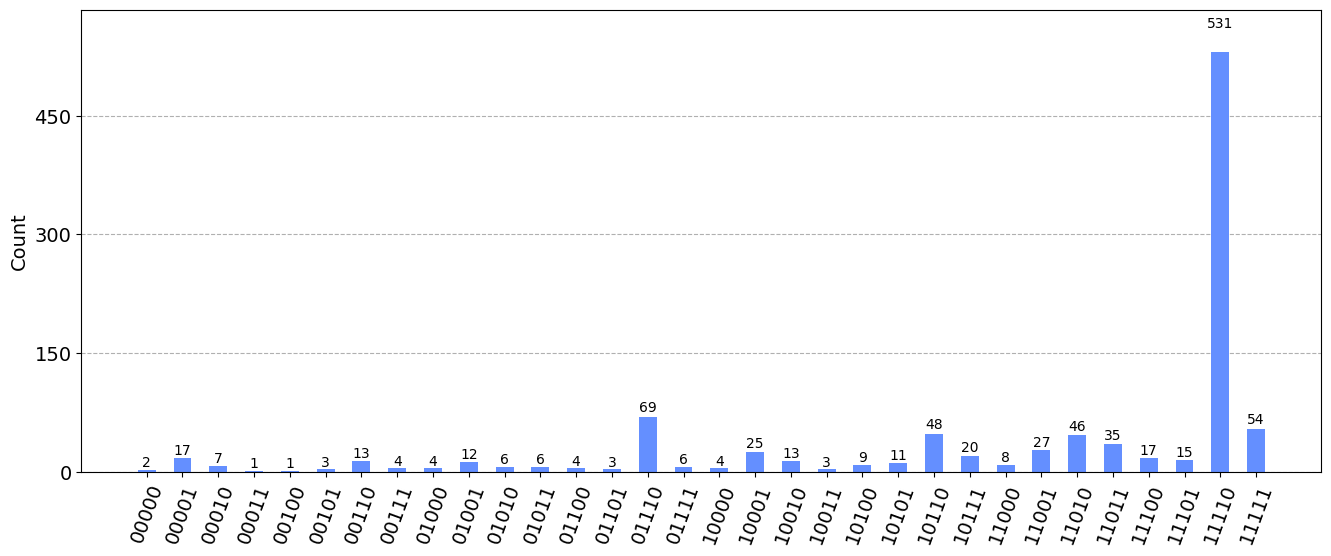

In [107]:

from qiskit.providers.fake_provider import FakeKolkata
from qiskit_aer.noise import NoiseModel

fake_backend = FakeKolkata()
noise_model = NoiseModel.from_backend(fake_backend)
basis_gates = noise_model.basis_gates
coupling_map = fake_backend.configuration().coupling_map

sim_noise = AerSimulator(noise_model=noise_model, basis_gates=basis_gates, coupling_map=coupling_map)

compiled = transpile(qc, sim_noise)
job = sim_noise.run(compiled, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts, figsize=(16, 6))
